# CNN with CIFAR dataset

In this section, we are going to construct convolutional neural network (CNN) by using `tf.keras`.

Also, we use color image named CIFAR dataset.

### 1. Load dependencies

First, we can load tf.keras and other python libraries.

In [4]:
import numpy as np
np.random.seed(2 ** 10)

import matplotlib.pyplot as plt

import tensorflow as tf
print("[INFO] Tensorflow version is {}".format(tf.__version__))

[INFO] Tensorflow version is 1.11.0


And then, we can load tensorflow eager model for better tensor management.

In [6]:
tf.enable_eager_execution()

### 2. Load dataset and pre-processing

In [19]:
# Load mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [20]:
# Pre-processing
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255.
x_test /= 255.

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10).astype(np.float32)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10).astype(np.float32)

print("Shape of x_train is {}".format(np.shape(x_train)))
print("Shape of x_test is {}".format(np.shape(x_test)))
print("Shape of y_train is {}".format(np.shape(y_train)))
print("Shape of y_test is {}".format(np.shape(y_test)))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 10)
Shape of y_test is (10000, 10)


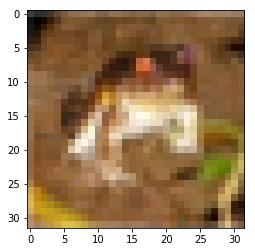

In [12]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0,:,:,:]*255.)

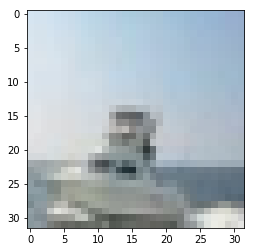

In [13]:
plt.imshow(x_train[100]*255.)

# 3. Construct tf.keras model

We can construct tensorflow model by using tf.keras.layers.

It's a lot easier than using an existing tensorflow, and the management of the tensor is clear.

In [21]:
# Build a tf.keras model
inputs = tf.keras.Input(shape=(32, 32, 3))

conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, 
                                                  kernel_initializer="he_normal",
                                                  kernel_regularizer=tf.keras.regularizers.l2(5e-4),
                                                  padding="same", activation=tf.nn.relu)(inputs)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv1)

conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, 
                                                   kernel_initializer="he_normal",
                                                   kernel_regularizer=tf.keras.regularizers.l2(5e-4),
                                                   padding="same", activation=tf.nn.relu)(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)

flatten = tf.keras.layers.Flatten()(pool2)
fc1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)(flatten)
fc2 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(fc1)

probabilities = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(fc2)

model = tf.keras.Model(inputs=[inputs], outputs=[probabilities])
model.summary()
print("Total parameters of model is {}".format(model.count_params()))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               524416    
__________

Now, we have to specify model's configuration.

In [22]:
opt = tf.train.RMSPropOptimizer(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 64
SHUFFLE_SIZE = 10000 

# 4. Dataset pipeline

We use the tf.data tensor flow library to construct the link between dataset and model.

Of course you can use Keras's basic model.fit method, but this example uses tf.data.

In [23]:
# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(SHUFFLE_SIZE)
dataset = dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(SHUFFLE_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

print(dataset)

<BatchDataset shapes: ((?, 32, 32, 3), (?, 10)), types: (tf.float32, tf.float32)>


# 5. Train model

Finally, train our model for checking accuracy!!

In [24]:
# Start training..!
for epoch in range(10):
    for (train_images, train_labels), (test_images, test_labels) in zip(dataset, test_dataset):
        loss, acc = model.train_on_batch(train_images, train_labels)
        test_loss, test_acc = model.test_on_batch(test_images, test_labels)
    print('Epoch #{}\t Loss: #{}\tAccuracy: #{}'.format(epoch + 1, test_loss, test_acc))
          
# Check model with full batches
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest Model \t\t Loss: %.6f\tAccuracy: %.6f' % (test_loss, test_acc))

Epoch #1	 Loss: #2.0995328426361084	Accuracy: #0.375
Epoch #2	 Loss: #1.4556081295013428	Accuracy: #0.5625
Epoch #3	 Loss: #1.0191731452941895	Accuracy: #0.8125
Epoch #4	 Loss: #1.4584349393844604	Accuracy: #0.5625
Epoch #5	 Loss: #1.751936912536621	Accuracy: #0.3125
Epoch #6	 Loss: #1.0858296155929565	Accuracy: #0.625
Epoch #7	 Loss: #0.8649528622627258	Accuracy: #0.6875
Epoch #8	 Loss: #0.7430163621902466	Accuracy: #0.875
Epoch #9	 Loss: #1.5803413391113281	Accuracy: #0.4375
Epoch #10	 Loss: #1.1307251453399658	Accuracy: #0.5625
313/313 [==============================] - 5s 16ms/step

Test Model 		 Loss: 1.271063	Accuracy: 0.605500


Performance is not good.

There are several reasons for this, but the main reason is the structure of the deep learning network.

So I hope you will improve the performance of the model!!

The following example shows how to configure a more diverse deep learning network.